<a href="https://colab.research.google.com/github/Jarin160/Potato-Diesease-Classification/blob/main/potato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
!unzip plantvillage.zip

Archive:  plantvillage.zip
   creating: plantvillage/
   creating: plantvillage/Potato___Early_blight/
  inflating: plantvillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: plantvillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: plantvillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: plantvillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: plantvillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: plantvillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: plantvillage/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: plantvillage/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG  
  inflating: plantvillage

In [5]:
image_size = 256
batch_size = 32
SEED = 123

data = tf.keras.preprocessing.image_dataset_from_directory('plantvillage', shuffle =True, image_size = image_size, batch_size = batch_size)

Found 2152 files belonging to 3 classes.


In [6]:
cls_names = data.class_names
cls_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

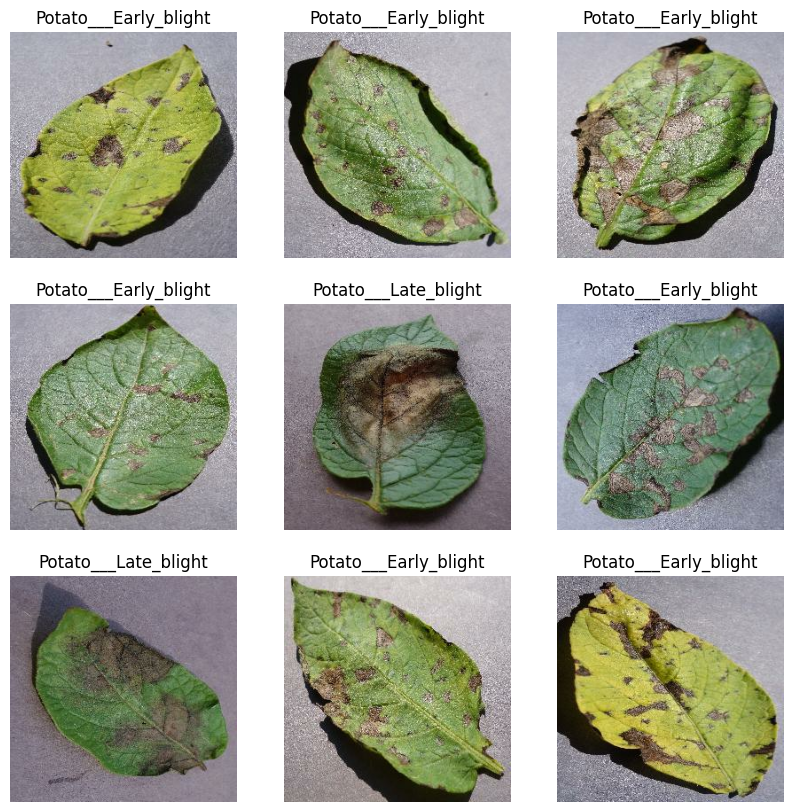

In [7]:
for img_batch, label_batch in data.take(1):
  plt.figure(figsize=(10,10))
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img_batch[i].numpy().astype("uint8"))
    plt.title(cls_names[label_batch[i]])
    plt.axis("off")

In [8]:
def get_train_test(data, train_split = 0.8, val_split = 0.1, test_split = 0.1,shuffle = True, shuffle_size = 10000):
  if shuffle:
    data = data.shuffle(shuffle_size, seed = 12)

  train_size = int(len(data)*train_split)
  val_size = int(len(data)*val_split)
  test_size = int(len(data)*test_split)

  train_data = data.take(train_size)
  val_data = data.skip(train_size).take(val_size)
  test_data = data.skip(train_size+val_size).take(test_size)

  return train_data, val_data, test_data

In [9]:
train_data, val_data, test_data = get_train_test(data)

print(len(train_data))
print(len(val_data))
print(len(test_data))

54
6
6


In [10]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
rescale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [12]:
from tensorflow.keras import Input

model = models.Sequential([
    Input(shape=(256, 256, 3)),
    rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
])

In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 40,
    batch_size = batch_size,
    verbose =1)

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.4484 - loss: 0.9663 - val_accuracy: 0.4323 - val_loss: 0.8562
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6609 - loss: 0.7763 - val_accuracy: 0.7500 - val_loss: 0.6073
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7848 - loss: 0.5427 - val_accuracy: 0.8073 - val_loss: 0.3998
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8701 - loss: 0.3128 - val_accuracy: 0.7969 - val_loss: 0.4551
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9018 - loss: 0.2539 - val_accuracy: 0.9115 - val_loss: 0.2267
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9165 - loss: 0.2118 - val_accuracy: 0.9375 - val_loss: 0.1645
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9250 - loss: 0.1799 - val_accuracy: 0.9375 - val_loss: 0.1665
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9110 - loss: 0.2398 - val_accuracy: 0.9583 - val_loss: 

In [16]:
scores = model.evaluate(test_data)
print(scores)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9950 - loss: 0.0202
[0.019455408677458763, 0.9947916865348816]


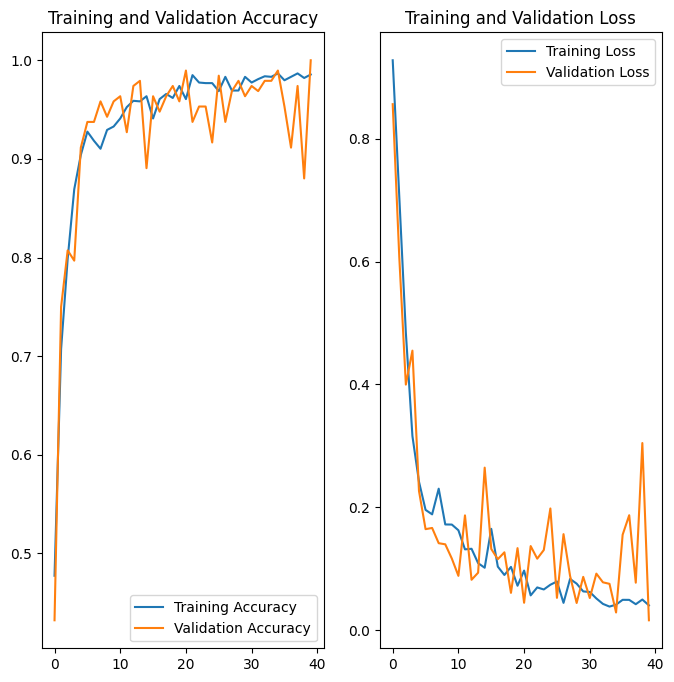

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(40), accuracy, label = 'Training Accuracy')
plt.plot(range(40), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(40), loss, label = 'Training Loss')
plt.plot(range(40), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


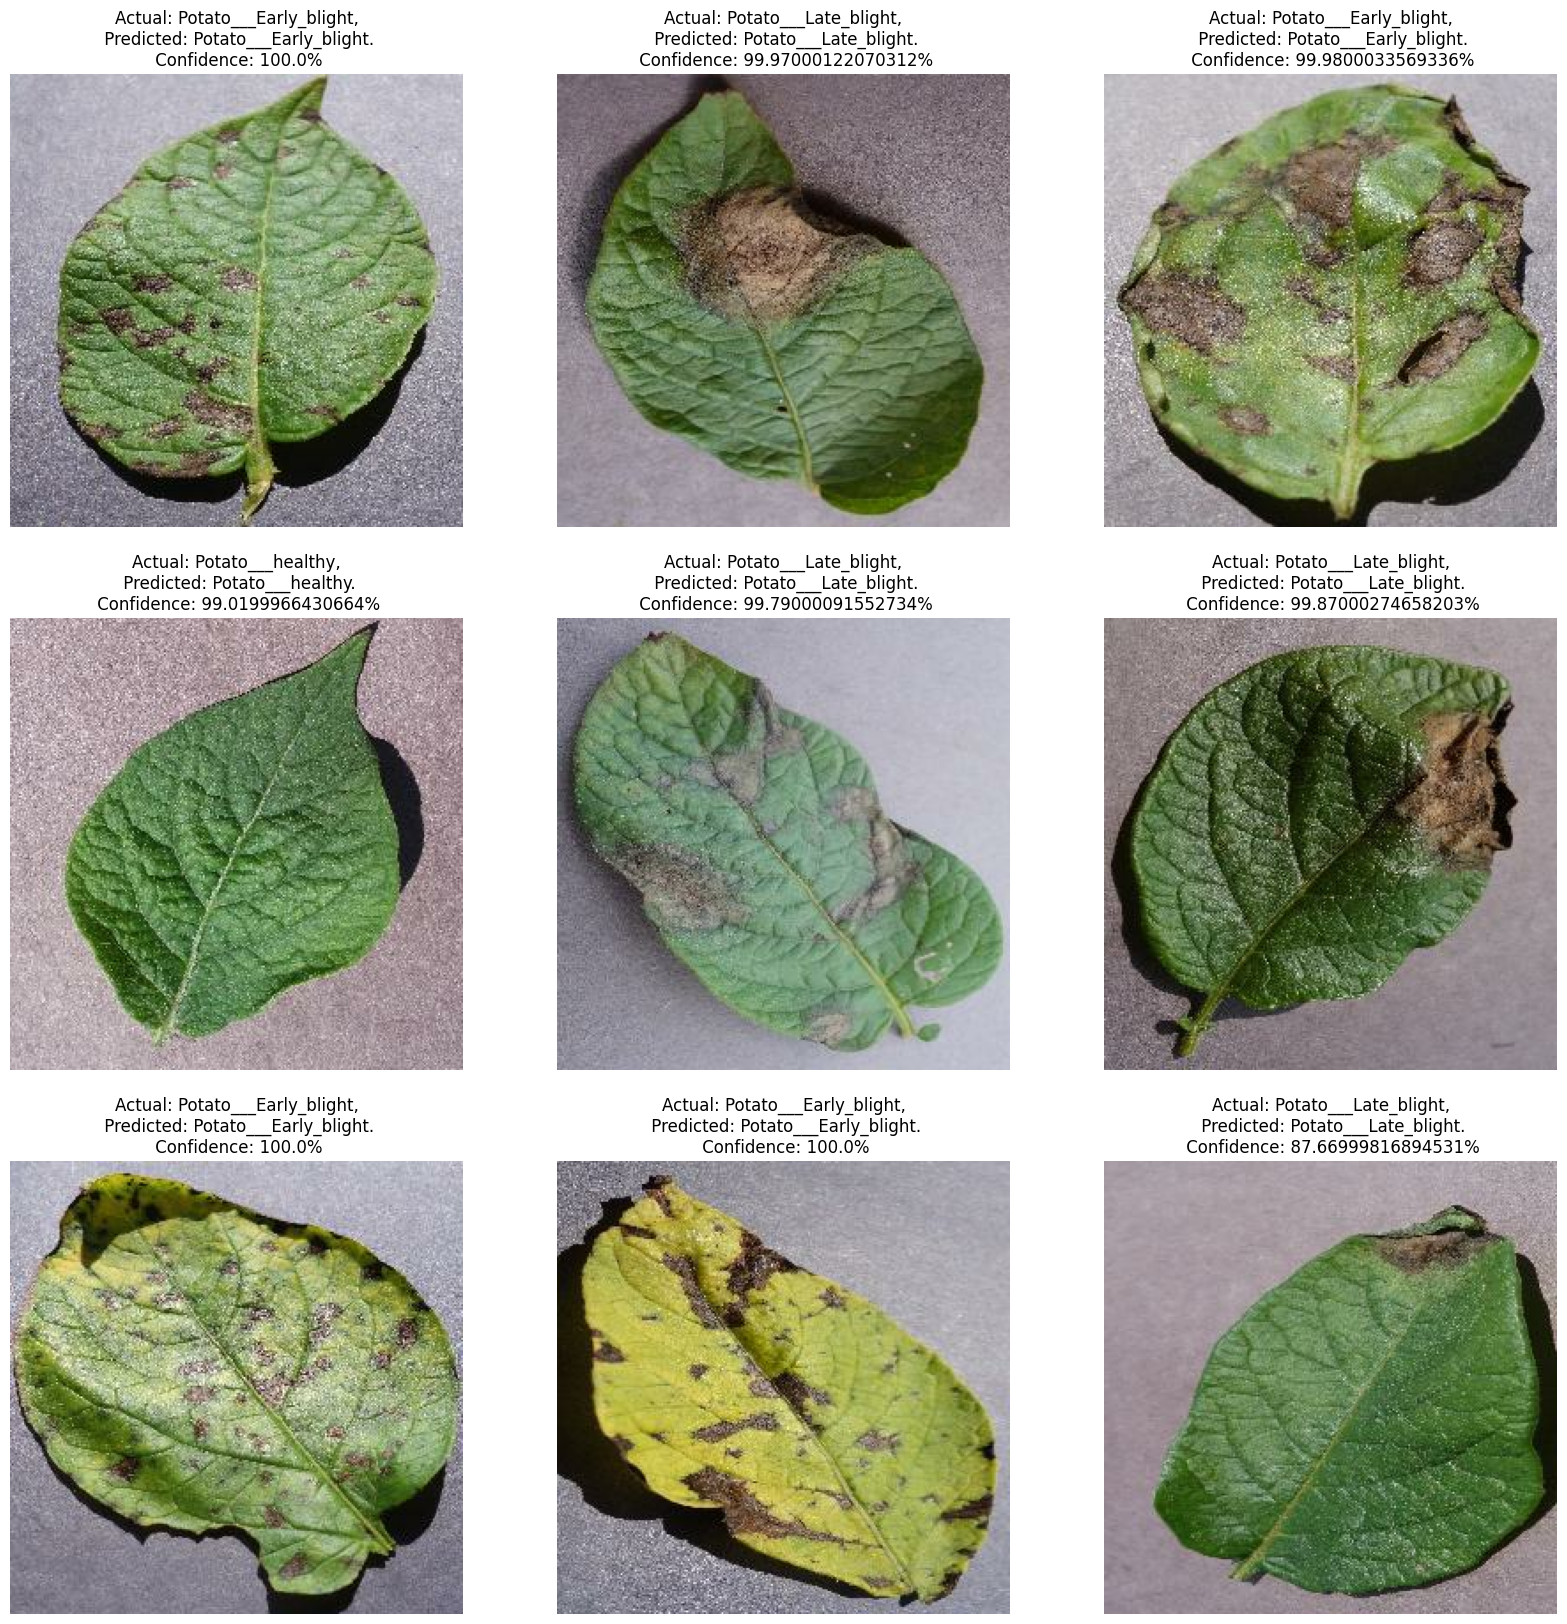

In [19]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = cls_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

plt.figure(figsize=(20,20))
for images, labels in test_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_cls, confidence = predict(model, images[i].numpy())
    actual_cls = cls_names[labels[i]]

    plt.axis("off")
    plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls}.\n Confidence: {confidence}%")